In [20]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import glob
import shutil as sh
import numpy as np
from sklearn import mixture
import math

print('Libraries loaded')

Libraries loaded


In [23]:
def OpenFits(FilePath):
    with fits.open(FilePath) as hdul:
        data = hdul[0].data
    return data

def ShowImage(Img,Title='',X='',Y=''):
    plt.imshow(Img)
    plt.title(Title)
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.show()
    plt.close()
    return

def ScatterImage(x,y,X='',Y='',Title=''):
    plt.scatter(x,y,s=0.1)
    plt.title(Title)
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.show()
    plt.close()
    return

def FitPercentile(LogMap,LogImage,Rotated,Threshold):
    
    plt.scatter(LogImage[0,:],LogImage[2,:],s=0.3)
    plt.title('Log values of two example bands')
    plt.xlabel('Log Flux Band 1')
    plt.ylabel('Log Flux Band 3')
    plt.show()
    plt.close()
    
    TotalFlux = np.zeros((LogImage.shape[1]))
    for a in range(0,LogImage.shape[0]):
        TotalFlux = TotalFlux + LogImage[a,:]
        
    Order = np.argsort(TotalFlux)
    
    Limit = int(math.floor(Threshold*LogImage.shape[1]/100))
    Number = LogImage.shape[1] - Limit
    
    Subset = np.zeros((LogImage.shape[0],Number))
    
    print('Subset shape: {0}'.format(Subset.shape))
    print('Rotated shape: {0}'.format(Rotated.shape))
    
    Count = 0
    for a in range(0,LogImage.shape[1]):
        if Order[a] > Limit:
            Subset[:,Count] = Rotated[:,a]
            Count = Count + 1
    
    Subset = Subset.T
    Rotated = Rotated.T
    
    gmix = mixture.GaussianMixture(n_components=2, covariance_type='full', max_iter=100, n_init=10)
    
    gmix.fit(Subset[:,1:])
    colours = gmix.predict(Rotated[:,1:])
    
    ObjectMap = np.zeros_like(LogMap)
    
    Count = 0
    for a in range(0,LogMap.shape[0]):
        for b in range(0,LogMap.shape[1]):
            if LogMap[a,b] == 1:
                ObjectMap[a,b] = colours[Count]+1
                Count = Count + 1
     
    plt.imshow(ObjectMap)
    plt.title('Object Map')
    plt.show()
    plt.close()

    Probabilities = gmix.predict_proba(Rotated[:,1:])

    ProbabilityMap = np.zeros((LogMap.shape[0],2*LogMap.shape[1]))
    
    Count = 0
    for a in range(0,LogMap.shape[0]):
        for b in range(0,LogMap.shape[1]):
            if LogMap[a,b] == 1:
                ProbabilityMap[a,b] = Probabilities[Count,0]
                ProbabilityMap[a,b+LogMap.shape[0]] = Probabilities[Count,1]
                Count = Count + 1  
                
    plt.imshow(ProbabilityMap)
    plt.title('Probability Map')
    plt.colorbar()
    plt.show()
    plt.close()
    
    return ProbabilityMap

def make_orthonormal_basis(ndims):
    ### ndims: input number of dimensions
    ### returns the basis vector array.
    ### The first vector is defined as [1,1,1,1.....]/sqrt(ndims).

    import numpy as np
    basis = -1 # default. Will apply for ndims<2, non-integer ndims etc.

    ### Define the ndims=2 case
    if(ndims == 2):
        basis = np.array([[1,1],[-1,1]])/np.sqrt(ndims)
        return basis

    ### for more than ndims=2, call this routine recursively to
    ### get the ndims-1 case sorted, then use gram-schmidt to get the
    ### final vector.
    if(ndims > 2):
        previous_basis = make_orthonormal_basis(ndims-1)
        ### Reset the primary vector
        primary_vector = np.ones(ndims) / np.sqrt(ndims)
        basis = np.zeros((ndims,ndims))
        basis[0] = primary_vector
        # equivalent of IDL's for i=1,ndims-2 do begin
        for i in range(1,ndims-1):
            # equivalent of IDL's basis[0:ndims-2,i] = previous_basis[*,i]
            basis[i][0:ndims-1] = previous_basis[i]
        ### use gram-schmidt to get the next basis vector
        ### see https://www.math.hmc.edu/calculus/tutorials/gramschmidt/
        u_n = np.zeros(ndims)
        u_n[ndims-1] = 1.0
        new_vector = u_n
        # equivalent of IDL's for i=0,ndims-2 do begin
        for i in range(0,ndims-1):
            ub = u_n * basis[i]
            new_vector = new_vector - ub.sum()*basis[i]
        ### this only guarantees an orthogonal new vector, so
        ### make sure this new vector is normalised to unity.
        nv2 = new_vector*new_vector
        new_vector = new_vector / np.sqrt(nv2.sum())
        ### Insert new vector into basis 
        basis[ndims-1] = new_vector
    return basis

def ShowFlux(ProbabilityMap,Image):
    
    ImageTriplet = np.zeros((Image.shape[0],Image.shape[1],3*Image.shape[2]))
    for a in range(0,Image.shape[0]):
        ImageTriplet[a,:,:Image.shape[2]] = np.multiply(ProbabilityMap[:,:Image.shape[2]],Image[a,:,:])
        ImageTriplet[a,:,Image.shape[2]:2*Image.shape[2]] = np.multiply(ProbabilityMap[:,Image.shape[2]:], Image[a,:,:])
        ImageTriplet[a,:,2*Image.shape[2]:] = Image[a,:,:]-ImageTriplet[a,:,:Image.shape[2]]-ImageTriplet[a,:,Image.shape[2]:2*Image.shape[2]]
    
    for a in range(0,Image.shape[0]):
        plt.imshow(ImageTriplet[a,:,:])
        plt.colorbar()
        plt.show()
        plt.close()

def RemoveBackground(Image):
    
    Image = Image/np.amax(Image)
    ForegroundMap = np.zeros((Image.shape[1],Image.shape[2]))
    Data = np.reshape(Image,(Image.shape[0],Image.shape[1]*Image.shape[2]))
    Data = Data.T
    gmix = mixture.GaussianMixture(n_components=2, covariance_type='full', max_iter=100, n_init=10)
    gmix.fit(Data)
    colours = gmix.predict(Data)
    Means = gmix.means_[:,:]
    ObjectA = Means[0,0] + Means[0,1]
    ObjectB = Means[1,0] + Means[1,1]
    
    if ObjectA > ObjectB:
        ForegroundMap[:,:] = 1-np.reshape(colours,(Image.shape[1],Image.shape[2]))
    else:
        ForegroundMap[:,:] = np.reshape(colours,(Image.shape[1],Image.shape[2]))
        
    plt.imshow(ForegroundMap)
    plt.title('Foreground Map')
    plt.show()
    plt.close()
    
    return ForegroundMap

def LogData(Image,ForegroundMap):
    
    LogMap = np.zeros((Image.shape[1],Image.shape[2]))
    
    for a in range(0,Image.shape[1]):
        for b in range(0,Image.shape[2]):
            if ForegroundMap[a,b] == 1:
                if not np.isnan(np.log10(Image[:,a,b])).any():
                    LogMap[a,b] = 1
                
    Total = np.sum(LogMap)
    
    Count = 0
    LogImage = np.zeros((Image.shape[0],int(Total)))
    for a in range(0,Image.shape[1]):
        for b in range(0,Image.shape[2]):
            if ForegroundMap[a,b] == 1:
                if not np.isnan(np.log10(Image[:,a,b])).any():
                    for c in range(0,Image.shape[0]):
                        LogImage[c,Count] = np.log10(Image[c,a,b])
                    Count = Count + 1
                    
    plt.imshow(LogMap)
    plt.title('Log Map')
    plt.show()
    plt.close()
    
    
    return LogMap, LogImage

class LensImage:
    def __init__(self, ID):
        FITS0 = OpenFits('/Users/AndrewDavies/Desktop/KiDSImages/imageSDSS_R-'+str(ID)+'.fits')
        FITS1 = OpenFits('/Users/AndrewDavies/Desktop/KiDSImages/imageSDSS_I-'+str(ID)+'.fits')
        FITS2 = OpenFits('/Users/AndrewDavies/Desktop/KiDSImages/imageSDSS_G-'+str(ID)+'.fits')
        FITS3 = OpenFits('/Users/AndrewDavies/Desktop/KiDSImages/imageSDSS_U-'+str(ID)+'.fits')
        self.FITS = [FITS0,FITS1,FITS2,FITS3]
        Output = np.zeros((4,FITS0.shape[0],FITS0.shape[1]))
        Output[0,:,:] = FITS0
        Output[1,:,:] = FITS1
        Output[2,:,:] = FITS2
        Output[3,:,:] = FITS3
        self.AllBands = Output
        Data0 = np.reshape(FITS0,(10201))/np.amax(Output)
        Data1 = np.reshape(FITS1,(10201))/np.amax(Output)
        Data2 = np.reshape(FITS2,(10201))/np.amax(Output)
        Data3 = np.reshape(FITS3,(10201))/np.amax(Output)
        self.DATA = [Data0,Data1,Data2,Data3]
        
        return

print('Functions loaded')

Functions loaded


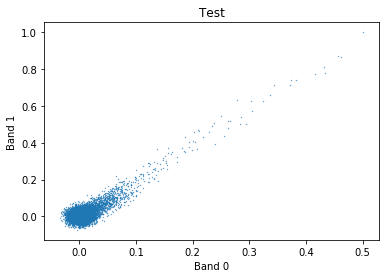

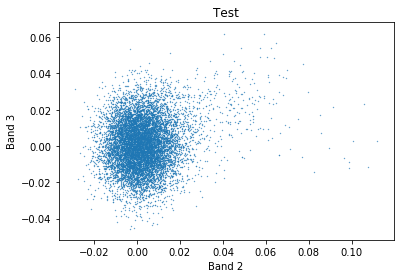

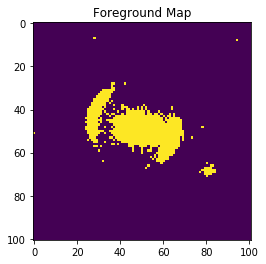

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in log10


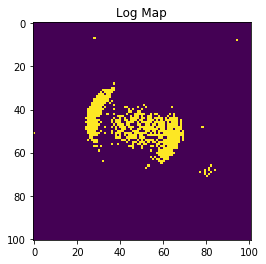

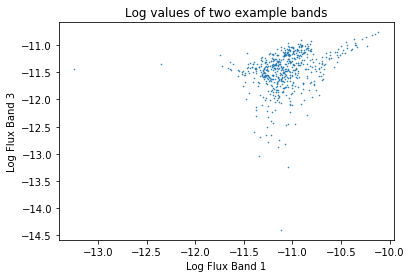

Subset shape: (4, 57)
Rotated shape: (4, 561)


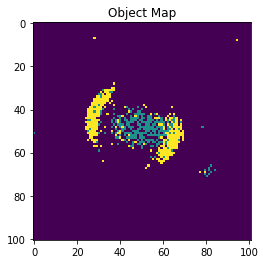

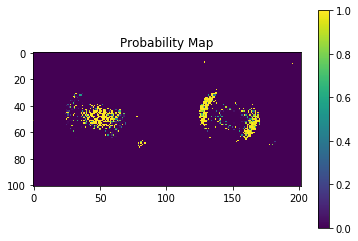

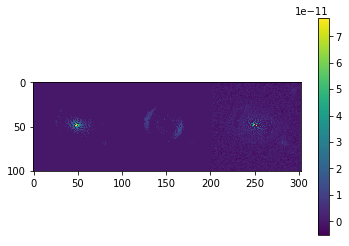

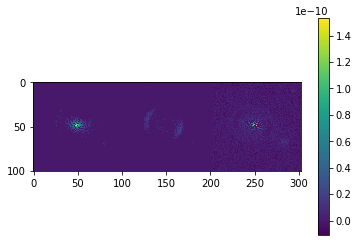

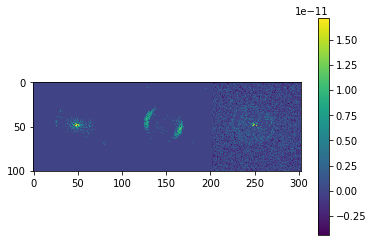

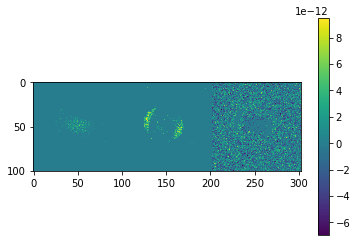

NameError: name 'TwoObjects' is not defined

In [24]:
Img100049 = LensImage('100049')
#ShowImage(Img100049.FITS[0])
#ShowImage(Img100049.FITS[1])
#ShowImage(Img100049.FITS[2])
#ShowImage(Img100049.FITS[3])

#plt.hist(Img100049.DATA[0])
#plt.show()
#plt.close()

Band0 = Img100049.DATA[0]/np.amax(Img100049.AllBands)
Band1 = Img100049.DATA[1]/np.amax(Img100049.AllBands)

ScatterImage(Img100049.DATA[0],Img100049.DATA[1],'Band 0','Band 1','Test')
ScatterImage(Img100049.DATA[2],Img100049.DATA[3],'Band 2','Band 3','Test')

Image = Img100049.AllBands

# Removes background and saves as an array
ForegroundMap = RemoveBackground(Image)

# Computes the log of the data, and removes data that can't be logged
LogMap, LogImage = LogData(Img100049.AllBands,ForegroundMap)

# Calculate rotation matrix
Matrix = make_orthonormal_basis(Image.shape[0])

# Rotate matrix
Rotated = np.dot(Matrix,LogImage)

ProbabilityMap = FitPercentile(LogMap,LogImage,Rotated,90)

ShowFlux(ProbabilityMap,Image)

TwoObjects()

Residuals()